In [2]:
# =============================================================================
# YOLO目标检测完整训练脚本
# 适用于Jupyter Notebook，按注释分块运行
# =============================================================================

# 块1：导入必要的库和设置
# 块1：导入必要的库和设置
import os
import json
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
from PIL import Image, ImageDraw
import random
from ultralytics import YOLO
import torch
import warnings  # 导入警告模块

# 设置中文字体显示为微软雅黑
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # 修改为微软雅黑
plt.rcParams['axes.unicode_minus'] = False

# 忽略警告信息
warnings.filterwarnings('ignore')  # 添加忽略警告的设置

# 设置随机种子
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

print("环境设置完成！")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
环境设置完成！


In [4]:
# =============================================================================
# 块2：数据格式转换函数定义
def json_to_yolo_format(json_path, img_width, img_height, class_mapping):
    """
    将JSON标注转换为YOLO格式
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    yolo_annotations = []
    
    # 处理标注信息
    if 'shapes' in data:
        for shape in data['shapes']:
            label = shape['label']
            if label in class_mapping:
                class_id = class_mapping[label]
                points = shape['points']
                
                # 计算边界框
                x_coords = [p[0] for p in points]
                y_coords = [p[1] for p in points]
                
                x_min, x_max = min(x_coords), max(x_coords)
                y_min, y_max = min(y_coords), max(y_coords)
                
                # 转换为YOLO格式 (中心点坐标和相对宽高)
                x_center = (x_min + x_max) / 2 / img_width
                y_center = (y_min + y_max) / 2 / img_height
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height
                
                yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    
    return yolo_annotations

def setup_yolo_dataset(source_dir, output_dir):
    """
    设置YOLO数据集格式
    """
    # 创建目录结构
    dataset_dirs = {
        'train_images': os.path.join(output_dir, 'images', 'train'),
        'val_images': os.path.join(output_dir, 'images', 'val'),
        'train_labels': os.path.join(output_dir, 'labels', 'train'),
        'val_labels': os.path.join(output_dir, 'labels', 'val')
    }
    
    for dir_path in dataset_dirs.values():
        os.makedirs(dir_path, exist_ok=True)
    
    # 类别映射
    class_mapping = {
        '聚酯电容': 0,
        '热敏电阻': 1, 
        '三端稳压管': 2
    }
    
    # 获取所有bmp文件
    bmp_files = [f for f in os.listdir(source_dir) if f.endswith('.bmp')]
    
    # 随机划分训练集和验证集 (80:20)
    random.shuffle(bmp_files)
    split_idx = int(len(bmp_files) * 0.8)
    train_files = bmp_files[:split_idx]
    val_files = bmp_files[split_idx:]
    
    def process_files(files, split):
        for bmp_file in files:
            # 构建文件路径
            img_path = os.path.join(source_dir, bmp_file)
            json_file = bmp_file.replace('.bmp', '.bmp.json')
            json_path = os.path.join(source_dir, json_file)
            
            if not os.path.exists(json_path):
                print(f"警告: 找不到标注文件 {json_file}")
                continue
            
            # 读取图片获取尺寸
            img = cv2.imread(img_path)
            if img is None:
                continue
            img_height, img_width = img.shape[:2]
            
            # 转换标注格式
            yolo_annotations = json_to_yolo_format(json_path, img_width, img_height, class_mapping)
            
            # 复制图片
            if split == 'train':
                dst_img = os.path.join(dataset_dirs['train_images'], bmp_file)
                dst_label = os.path.join(dataset_dirs['train_labels'], bmp_file.replace('.bmp', '.txt'))
            else:
                dst_img = os.path.join(dataset_dirs['val_images'], bmp_file)
                dst_label = os.path.join(dataset_dirs['val_labels'], bmp_file.replace('.bmp', '.txt'))
            
            shutil.copy2(img_path, dst_img)
            
            # 保存标注文件
            with open(dst_label, 'w') as f:
                f.write('\n'.join(yolo_annotations))
    
    process_files(train_files, 'train')
    process_files(val_files, 'val')
    
    print(f"数据集划分完成:")
    print(f"训练集: {len(train_files)} 张图片")
    print(f"验证集: {len(val_files)} 张图片")
    
    return dataset_dirs, class_mapping

In [5]:
# =============================================================================
# 块3：执行数据格式转换
source_directory = "/mnt/workspace/data"  # 修改为您的数据集路径
output_directory = "/mnt/workspace/yolo_data"

# 如果您的数据在当前目录，可以这样设置
# source_directory = "./"  

dataset_dirs, class_mapping = setup_yolo_dataset(source_directory, output_directory)
print("数据格式转换完成！")

[ERROR:0@126.344] global loadsave.cpp:507 imread_ imread_('/mnt/workspace/data/(8).bmp'): can't read data: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/bitstrm.cpp:67: error: (-2:Unspecified error) Unexpected end of input stream in function 'readBlock'



数据集划分完成:
训练集: 50 张图片
验证集: 13 张图片
数据格式转换完成！


In [9]:
# =============================================================================
# 块4：创建YOLO配置文件
def create_yaml_config(output_dir, class_mapping):
    """
    创建YOLO训练配置文件
    """
    config = {
        'path': os.path.abspath(output_dir),
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(class_mapping),
        'names': {v: k for k, v in class_mapping.items()}
    }
    
    yaml_path = os.path.join(output_dir, 'dataset.yaml')
    with open(yaml_path, 'w', encoding='utf-8') as f:
        yaml.dump(config, f, default_flow_style=False, allow_unicode=True)
    
    return yaml_path

yaml_config_path = create_yaml_config(output_directory, class_mapping)
print(f"配置文件已创建: {yaml_config_path}")

配置文件已创建: /mnt/workspace/yolo_data/dataset.yaml


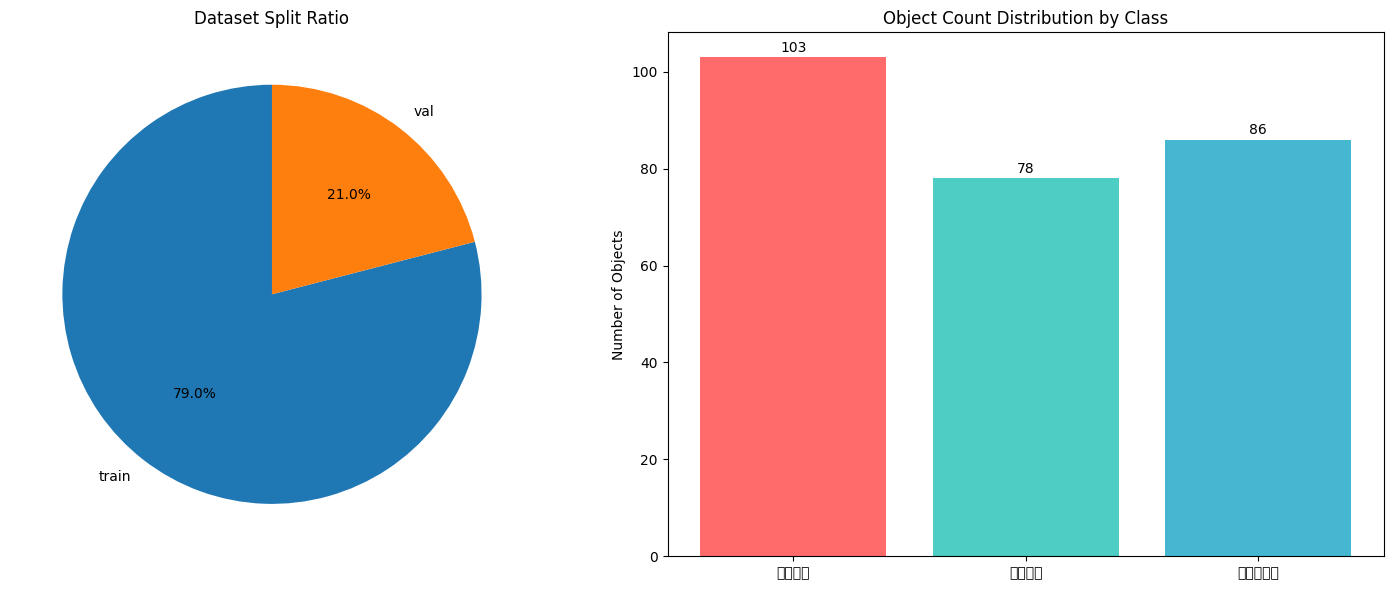

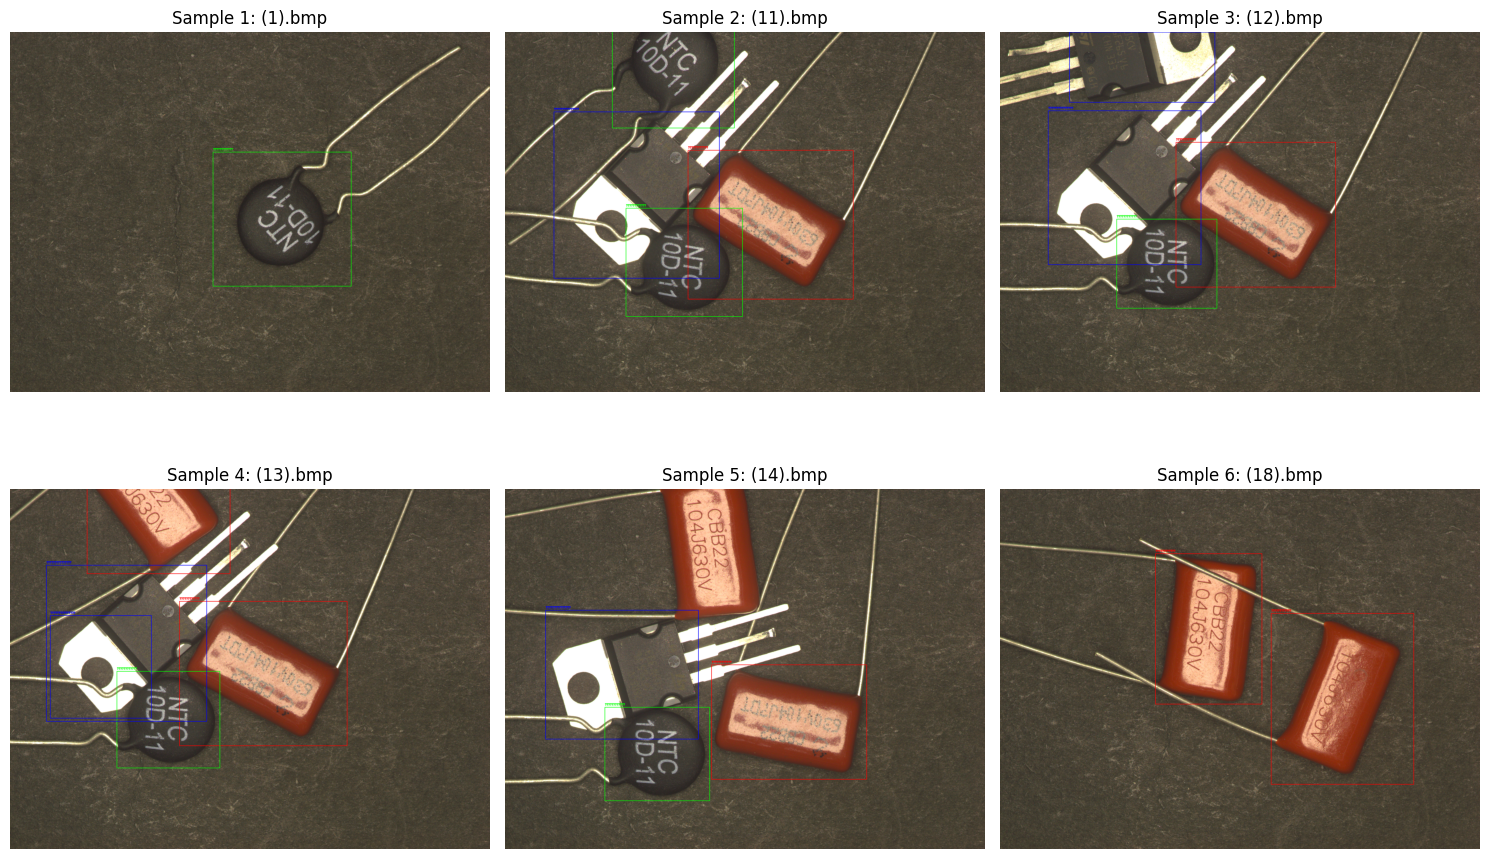

In [6]:
# =============================================================================
# Block 5: Data Visualization Functions
def visualize_dataset_statistics(dataset_dirs, class_mapping):
    """
    Visualize dataset statistical information
    """
    # Count the number of objects in each class
    class_counts = {name: 0 for name in class_mapping.keys()}
    image_counts = {'train': 0, 'val': 0}
    
    for split in ['train', 'val']:
        label_dir = dataset_dirs[f'{split}_labels']
        image_counts[split] = len(os.listdir(dataset_dirs[f'{split}_images']))
        
        for label_file in os.listdir(label_dir):
            if label_file.endswith('.txt'):
                label_path = os.path.join(label_dir, label_file)
                with open(label_path, 'r') as f:
                    for line in f:
                        if line.strip():
                            class_id = int(line.split()[0])
                            class_name = list(class_mapping.keys())[class_id]
                            class_counts[class_name] += 1
    
    # Create visualization charts
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Figure 1: Dataset split
    splits = list(image_counts.keys())
    counts = list(image_counts.values())
    axes[0].pie(counts, labels=splits, autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Dataset Split Ratio')
    
    # Figure 2: Class distribution
    classes = list(class_counts.keys())
    class_nums = list(class_counts.values())
    bars = axes[1].bar(classes, class_nums, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[1].set_title('Object Count Distribution by Class')
    axes[1].set_ylabel('Number of Objects')
    
    # Add values on bar chart
    for bar, count in zip(bars, class_nums):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return class_counts, image_counts

def visualize_sample_images(dataset_dirs, class_mapping, num_samples=6):
    """
    Visualize sample images and annotations
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    train_img_dir = dataset_dirs['train_images']
    train_label_dir = dataset_dirs['train_labels']
    
    img_files = os.listdir(train_img_dir)[:num_samples]
    
    class_colors = {0: (255, 0, 0), 1: (0, 255, 0), 2: (0, 0, 255)}  # RGB
    class_names = {v: k for k, v in class_mapping.items()}
    
    for idx, img_file in enumerate(img_files):
        if idx >= num_samples:
            break
            
        # Read image
        img_path = os.path.join(train_img_dir, img_file)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Read annotations
        label_file = img_file.replace('.bmp', '.txt')
        label_path = os.path.join(train_label_dir, label_file)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    if line.strip():
                        parts = line.strip().split()
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:])
                        
                        # Convert to pixel coordinates
                        img_h, img_w = img.shape[:2]
                        x_center *= img_w
                        y_center *= img_h
                        width *= img_w
                        height *= img_h
                        
                        x1 = int(x_center - width/2)
                        y1 = int(y_center - height/2)
                        x2 = int(x_center + width/2)
                        y2 = int(y_center + height/2)
                        
                        # Draw bounding box
                        color = class_colors[class_id]
                        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
                        cv2.putText(img_rgb, class_names[class_id], (x1, y1-10), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f'Sample {idx+1}: {img_file}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Execute data visualization
class_counts, image_counts = visualize_dataset_statistics(dataset_dirs, class_mapping)
visualize_sample_images(dataset_dirs, class_mapping)

In [7]:
# =============================================================================
# 块6：数据增强配置
def setup_data_augmentation():
    """
    设置数据增强参数
    """
    augmentation_config = {
        'hsv_h': 0.015,      # 色调变化
        'hsv_s': 0.7,        # 饱和度变化
        'hsv_v': 0.4,        # 明度变化
        'degrees': 10.0,      # 旋转角度
        'translate': 0.1,     # 平移
        'scale': 0.5,        # 缩放
        'shear': 0.0,        # 剪切
        'perspective': 0.0,   # 透视变换
        'flipud': 0.0,       # 上下翻转
        'fliplr': 0.5,       # 左右翻转
        'mosaic': 1.0,       # 马赛克增强
        'mixup': 0.0,        # 混合增强
        'copy_paste': 0.0    # 复制粘贴增强
    }
    
    return augmentation_config

augmentation_params = setup_data_augmentation()
print("数据增强参数配置完成")

数据增强参数配置完成


In [11]:
# =============================================================================
# 块7：模型训练
def train_yolo_model(yaml_path, epochs=20, batch_size=8, img_size=640):
    """
    训练YOLO模型
    """
    # 加载预训练模型
    model = YOLO('./yolo11n.pt')  # 会自动下载预训练权重
    
    # 训练配置
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        batch=batch_size,
        imgsz=img_size,
        patience=20,
        save=True,
        device=0,  # 自动选择GPU或CPU
        **augmentation_params
    )
    
    return model, results

print("开始训练模型...")
model, training_results = train_yolo_model(yaml_config_path, epochs=50, batch_size=8)
print("模型训练完成！")

开始训练模型...
Ultralytics 8.3.162 🚀 Python-3.11.11 torch-2.3.1+cu121 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: gpu
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


In [12]:
import torch
print("=== CUDA 诊断信息 ===")
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA是否可用: {torch.cuda.is_available()}")
print(f"CUDA设备数量: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"当前CUDA设备: {torch.cuda.current_device()}")
    print(f"CUDA设备名称: {torch.cuda.get_device_name()}")
else:
    print("CUDA不可用，将使用CPU训练")

# 检查环境变量
import os
cuda_visible = os.environ.get('CUDA_VISIBLE_DEVICES', '未设置')
print(f"CUDA_VISIBLE_DEVICES: {cuda_visible}")

=== CUDA 诊断信息 ===
PyTorch版本: 2.3.1+cu121
CUDA是否可用: False
CUDA设备数量: 0
CUDA不可用，将使用CPU训练
CUDA_VISIBLE_DEVICES: 0
